<a href="https://colab.research.google.com/github/WRFitch/fyp/blob/main/src/fyp_demonstration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FYP Demonstration
### Will Fitch 1633241 
### Brunel University Department of Computer Science

This notebook is a demonstration of my final year project, in which I have used neural networks and transfer learning to infer highly detailed greenhouse gas information from satellite data. 

## Setup 

### Imports

In [ ]:
import ee
import folium
import os

from fastai.vision.all import *
from google.colab import drive
from IPython.display import Image
from osgeo import gdal
from PIL import Image

#### Parts that require human input 

In [ ]:
# Sometimes fastai doesn't want to play with colab, so we remove it and replace 
# it with a compliant version just to be sure. 
!pip uninstall -y fastai
!pip install -U --no-cache-dir fastai

In [ ]:
ee.Authenticate()
ee.Initialize()
drive.mount('/content/drive')

In [ ]:
# Import fyputil library
# EE stuff needs initialising first
%cd /content
!git clone https://github.com/WRFitch/fyp.git
%cd fyp/src/fyputil
import constants as c
import ee_constants as eec
import ee_utils as eeutil
import fyp_utils as fyputil
%cd /content

#### Parts that don't require human input 

In [ ]:
drive_path = "/content/drive/MyDrive/"
demo_dir = "demo_export"
demo_path = f"{drive_path}{demo_dir}"
model_dir = f"{drive_path}/models"

In [ ]:
model_name = "resnet152_MRGHG_Demo1"

# Add a dummy label script to fool fastai into letting us import the model. 
# We're not going to train the model further, so this is fine. 
def getGhgsAsArr(img_path):
  return np.array()

model = load_learner(f"{model_dir}/{model_name}.pkl")

In [ ]:
def geotiffToPng(tif_path, rm_artifacts = False):
  # Define rgb bands and image encoding (?)
  options_list = [
    '-ot Byte',
    '-of PNG',
    '-b 4',
    '-b 3',
    '-b 2',
    '-scale'
  ]
  options_string = " ".join(options_list)
  path = os.path.splitext(tif_path)[0]

  if os.path.isfile(f"{path}.png"):
    print(f"A png file already exists for {tif_path}")
    return
      
  gdal.Translate(
    path + '.png',
    path + '.tif',
    options = options_string
  )
  os.remove(f"{path}.png.aux.xml")
  print(f"Converted file from GeoTIFF to PNG")

# Parses postcode into coordinates (obviously only works in the UK)
def getCoordinatesFromPostcode(postcode):
  print(postcode)
  return (0,0)

def getGhgsFromCoords(coords):
  img_path = importImg(coords)
  print(img_path)
  ghgs = getGhgsFromImg(img_path)
  displayGhgs(ghgs)
  displayHealthDefects(ghgs)
  displayEnvEffects(ghgs)

# use image pipeline to download an image based on a point object defined by the 
# given coordinates
def importImg(coords):
  # get a square from the given image. 
  # TODO why is this buffer 500? the ideal pixel size should be 224, so 2240m. 
  polygon = ee.Geometry.Point(coords).buffer(500).bounds()

  name = f"{coords[0]}_{coords[1]}"
  tifname = f"{name}.tif"

  # check if image is cached before importing from GEE
  cachePath = f"{demo_path}/{name}.png"
  if os.path.isfile(cachePath): 
    print("image for these coordinates has already been imported!")
    return cachePath

  print(f"importing {tifname}")
  exportGeotiff(s2_img, polygon, 10, demo_dir, name)
  tifpath = f"{demo_path}/{tifname}"
  while not os.path.isfile(tifpath):
    time.sleep(5)
  print(f"imported  {tifname}")
  
  # Convert GeoTIFF to PNG.
  geotiffToPng(tifpath, rm_artifacts = True)
  print(f"{tifpath} converted to PNG")

  importPath = f"{demo_path}/{name}.png"
  if os.path.isfile(importPath): return importPath

  print("image import failed")

# Export one GeoTIFF image of the given image, at the scale and dimensions specified. 
def exportGeotiff(image, polygon, scale, folder="no_export_folder", desc="no_desc"):
  ee.batch.Export.image.toDrive(
    crs = 'EPSG:3857',
    description = desc,
    fileFormat = 'GeoTIFF',
    folder = folder,
    image = image,
    maxPixels = 10e9,
    region = polygon,
    scale = scale
  ).start()

def getGhgsFromImg(img_path):
  print("getting GHG concentrations from given image")
  display(Image.open(img_path))
  predictions = model.predict(img_path)[0]
  print(predictions)
  return predictions 

def displayGhgs(ghgs):
  print(ghgs)
  # Add ghgs to table
  # compare against average
  # display ghgs as a series of plots. 
  # for each ghg concentration, display health defects and mitigation strategies 
  # on table
  # print table

def displayHealthDefects(ghgs):
  print(ghgs)
  # for each ghg, compare against concentration. Depending on how high they are,
  # display the potential health effects and their likelihoods. 
  # return dict of ghg to string tuples of horrible effects and their likelihoods. 

def displayEnvEffects(ghgs):
  print(ghgs)
  # for each ghg, compare against concentration. Depending on how high they are, 
  # display the potential environmental effects and their likelihoods. 
  # return dict of ghg to string tuples of horrible effects and their likelihoods. 

# Run all the above code to ensure it works fine and is initialised ok. A lot of 
# python efficiency requires precaching this stuff into memory, so on the day 
# run this beforehand
def demoTest():
  getCoordinatesFromPostcode("UB8 3PH")  

demoTest()

UB8 3PH


## Demonstration

### Map Visualisation 

#### Setup

In [ ]:
great_britain = ee.Geometry.Polygon(
        [[[-1.836112801004015, 59.808076330562756],
          [-8.779472176004015, 58.82140293049428],
          [-7.988456551004015, 55.71069203454839],
          [-11.196464363504015, 54.42753859549109],
          [-11.328300301004015, 50.967746003015044],
          [-9.526542488504015, 50.77361752815123],
          [-6.274589363504015, 51.81776248652293],
          [-5.395683113504015, 51.21615275310099],
          [-6.582206551004015, 49.56332371186494],
          [-3.110526863504015, 49.904165426606255],
          [1.240059073995985, 50.80139967619036],
          [2.426582511495985, 52.33095407387208],
          [1.767402823995985, 53.4183511305661],
          [0.5369340739959849, 53.44453305344514],
          [-1.616386238504015, 56.32474216074427],
          [-0.7814253010040151, 57.805828290000164]]])

CO_band = 'CO_column_number_density'
HCHO_band = 'tropospheric_HCHO_column_number_density'
NO2_band = 'tropospheric_NO2_column_number_density'
O3_band = 'O3_column_number_density'
SO2_band = 'SO2_column_number_density'
CH4_band = 'CH4_column_volume_mixing_ratio_dry_air'
ghg_bands = [CO_band, HCHO_band, NO2_band, O3_band, SO2_band, CH4_band]

s2 = ee.ImageCollection("COPERNICUS/S2_SR")
s5_CO = ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_CO")
s5_HCHO = ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_HCHO")
s5_NO2 = ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_NO2")
s5_O3 = ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_O3")
s5_SO2 = ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_SO2")
s5_CH4 = ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_CH4")

start_date = '2020-01-01'
end_date = '2020-12-31'
vis_palette = ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']

In [ ]:
# pre-filter to remove clouds. We can add them back in from sentinel 5 if necessary
def maskS2clouds(image) :
  qa = image.select('QA60');

  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloud_bitmask = 1 << 10
  cirrus_bitmask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
  mask = qa.bitwiseAnd(cloud_bitmask).eq(0).And( \
         qa.bitwiseAnd(cirrus_bitmask).eq(0))

  return image.updateMask(mask).divide(10000)

# High-resolution satellite photograph 
s2_img = s2.filterDate(start_date, end_date) \
           .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
           .filterBounds(great_britain) \
           .map(maskS2clouds).median()
s2_id = s2_img.getMapId({'bands': ['B4', 'B3', 'B2'], \
                        'min': 0, \
                        'max': 0.3})

# Carbon monoxide
# Minmax scale is a bit off - recalibrate for Britain 
CO_img = s5_CO.filterDate(start_date, end_date) \
              .filterBounds(great_britain) \
              .select(CO_band).mean()
CO_id = CO_img.getMapId( \
    {'palette': vis_palette, \
    'min': 0, \
    'max': 0.05})

# Formaldehyde
# Minmax scale is a bit off - recalibrate for Britain
HCHO_img = s5_HCHO.filterDate(start_date, end_date) \
                  .filterBounds(great_britain) \
                  .select(HCHO_band).mean()
HCHO_id = HCHO_img.getMapId( \
    {'palette': vis_palette, \
    'min': 0.0, \
    'max': 0.0003})

# Nitrogen Dioxide
NO2_img = s5_NO2.filterDate(start_date, end_date) \
                .filterBounds(great_britain) \
                .select(NO2_band).mean()
NO2_id = NO2_img.getMapId( \
    {'palette': vis_palette, \
    'min': 0.0, \
    'max': 0.0002})

# Ozone
O3_img = s5_O3.filterDate(start_date, end_date) \
              .filterBounds(great_britain) \
              .select(O3_band).mean()
O3_id = O3_img.getMapId( \
    {'palette': vis_palette, \
    'min': 0.12, \
    'max': 0.15})

# Sulphur Dioxide
SO2_img = s5_SO2.filterDate(start_date, end_date) \
                .filterBounds(great_britain) \
                .select(SO2_band).mean()
SO2_id = SO2_img.getMapId( \
    {'palette': vis_palette, \
    'min': 0.0, \
    'max': 0.0005})

# Methane
CH4_img = s5_CH4.filterDate(start_date, end_date) \
                .filterBounds(great_britain) \
                .select(CH4_band).mean()
CH4_id = CH4_img.getMapId( \
    {'palette': vis_palette, \
    'min': 1750, \
    'max': 1900})

ghg_imgs = [CO_img, HCHO_img, NO2_img, O3_img, SO2_img, CH4_img]
ghg_ids = [CO_id, HCHO_id, NO2_id, O3_id, SO2_id, CH4_id]

In [ ]:
# Visualise data on a Folium map 
# Attribute maps to earthengine.google.com 
map = folium.Map(
    location = [51.5, 0.1], 
    prefer_canvas = True)

layerOpacity = 0.5

folium.TileLayer(
    tiles = s2_id['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay = True,
    name = 'satellite photography median composite '
  ).add_to(map)

folium.TileLayer(
    tiles = CO_id['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay = True,
    name = 'Carbon Monoxide',
    opacity = layerOpacity
  ).add_to(map)

folium.TileLayer(
    tiles = HCHO_id['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay = True,
    name = 'Formaldehyde',
    opacity = layerOpacity
  ).add_to(map)

folium.TileLayer(
    tiles = NO2_id['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay = True,
    name = 'Nitrogen Dioxide',
    opacity = layerOpacity
  ).add_to(map)

folium.TileLayer(
    tiles = O3_id['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay = True,
    name = 'Ozone',
    opacity = layerOpacity
  ).add_to(map)

folium.TileLayer(
    tiles = SO2_id['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay = True,
    name = 'Sulphur Dioxide',
    opacity = layerOpacity
  ).add_to(map)

folium.TileLayer(
    tiles = CH4_id['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay = True,
    name = 'Methane',
    opacity = layerOpacity
  ).add_to(map)
  
map.add_child(folium.LayerControl())

### Visualisation 

In [ ]:
map

### Model Interpolation

image for these coordinates has already been imported!
/content/drive/MyDrive/demo_export/-0.47278354461716354_51.53325658151181.png
/content/drive/MyDrive/demo_export/-0.47278354461716354_51.53325658151181.png
getting GHG concentrations from given image


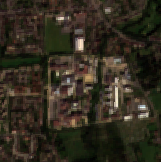

(3.3318734169006348, 6.314513206481934, 6.085233211517334, 1.3520294427871704, 2.8814358711242676, 1.714736819267273)
(3.3318734169006348, 6.314513206481934, 6.085233211517334, 1.3520294427871704, 2.8814358711242676, 1.714736819267273)
(3.3318734169006348, 6.314513206481934, 6.085233211517334, 1.3520294427871704, 2.8814358711242676, 1.714736819267273)
(3.3318734169006348, 6.314513206481934, 6.085233211517334, 1.3520294427871704, 2.8814358711242676, 1.714736819267273)


In [ ]:
#@title Insert Postcode

# list of coords 
brunel = (-0.47278354461716354, 51.53325658151181)
# big_ben
# dickens
# somewhere grassy

# Testing on some weird places - desert, ocean, tundra

getGhgsFromCoords(brunel)